In [1]:
# Adds link to the scripts folder
import sys
import os
sys.path.append("../../scripts/")
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from trajectory import Trajectory, load_trajectory_dict
from hivevo.patients import Patient
import filenames
import copy
from activity import get_average_activity
from proba_fix import get_proba_fix

# Activity plots

## Functions

Format of the dictionnaries : trajectories[region][rev/non_rev/syn/non_syn]

In [2]:
def get_mean_in_time(trajectories, nb_bins=20, freq_range=[0.4, 0.6]):
    """
    Computes the mean frequency in time of a set of trajectories from the point they are seen in the freq_range window.
    Returns the middle of the time bins and the computed frequency mean.
    """
    # Create bins and select trajectories going through the freq_range
    time_bins = np.linspace(-677, 3000, nb_bins)
    trajectories = [traj for traj in trajectories if np.sum(np.logical_and(
        traj.frequencies >= freq_range[0], traj.frequencies < freq_range[1]), dtype=bool)]

    # Offset trajectories to set t=0 at the point they are seen in the freq_range and adds all the frequencies / times
    # to arrays for later computation of mean
    t_traj = np.array([])
    f_traj = np.array([])
    for traj in trajectories:
        idx = np.where(np.logical_and(traj.frequencies >=
                                      freq_range[0], traj.frequencies < freq_range[1]))[0][0]
        traj.t = traj.t - traj.t[idx]
        t_traj = np.concatenate((t_traj, traj.t))
        f_traj = np.concatenate((f_traj, traj.frequencies))

    # Binning of all the data in the time bins
    filtered_fixed = [traj for traj in trajectories if traj.fixation == "fixed"]
    filtered_lost = [traj for traj in trajectories if traj.fixation == "lost"]
    freqs, fixed, lost = [], [], []
    for ii in range(len(time_bins) - 1):
        freqs = freqs + [f_traj[np.logical_and(t_traj >= time_bins[ii], t_traj < time_bins[ii + 1])]]
        fixed = fixed + [len([traj for traj in filtered_fixed if traj.t[-1] < time_bins[ii]])]
        lost = lost + [len([traj for traj in filtered_lost if traj.t[-1] < time_bins[ii]])]

    # Computation of the mean in each bin, active trajectories contribute their current frequency,
    # fixed contribute 1 and lost contribute 0
    mean = []
    for ii in range(len(freqs)):
        mean = mean + [np.sum(freqs[ii]) + fixed[ii]]
        mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])

    nb_active = [len(freq) for freq in freqs]
    nb_dead = [fixed[ii] + lost[ii] for ii in range(len(fixed))]

    return 0.5 * (time_bins[1:] + time_bins[:-1]), mean, nb_active, nb_dead
    
    
    
def make_mean_in_time_dict(trajectories):
    regions = ["env", "pol", "gag", "all"]
    means = {}
    freq_ranges = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8]]
    times = []

    for freq_range in freq_ranges:
        means[str(freq_range)] = {}
        for region in regions:
            means[str(freq_range)][region] = {}
            for key in trajectories[region].keys():
                times, means[str(freq_range)][region][key], _, _ = get_mean_in_time(trajectories[region][key], freq_range=freq_range)
    return times, means, freq_ranges

def make_pfix(nb_bin=8):
    regions = ["env", "pol", "gag", "all"]
    pfix = {}
    for region in regions:
        pfix[region] = {}
        for key in trajectories[region].keys():
            tmp_freq_bin, tmp_proba, tmp_err = get_proba_fix(trajectories[region][key], nb_bin=nb_bin)
            pfix[region][key] = {"freq_bin": tmp_freq_bin, "proba": tmp_proba, "error": tmp_err}
    return pfix

## Mean in time

In [3]:
trajectories = load_trajectory_dict("../../trajectory_dict")
times, means, freq_ranges = make_mean_in_time_dict(trajectories)
pfix = make_pfix(nb_bin=8)

/home/valentin/miniconda3/envs/HIV/lib/python3.8/site-packages/numpy/ma/core.py:2794: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


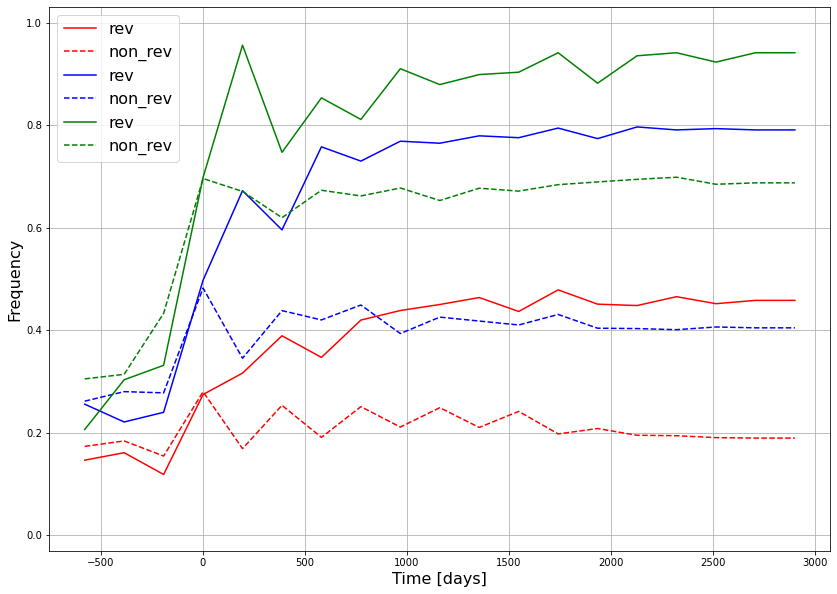

In [4]:
def plot_mean(times, means, savefig=False, fontsize=16):
    freq_ranges = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8]]
    colors = ["r","b","g"]
    
    plt.figure(figsize=(14,10))
    for ii, freq_range in enumerate(freq_ranges):
        plt.plot(times, means[str(freq_range)]["all"]["rev"], "-", color=colors[ii], label="rev")
        plt.plot(times, means[str(freq_range)]["all"]["non_rev"], "--", color=colors[ii], label="non_rev")

    plt.xlabel("Time [days]", fontsize=fontsize)
    plt.ylabel("Frequency", fontsize=fontsize)
    plt.ylim([-0.03, 1.03])
    plt.grid()
    plt.legend(fontsize=fontsize)
    
    if savefig:
        plt.savefig(savefig+".pdf", format="pdf")
    plt.show()
    
trajectories = load_trajectory_dict("../../trajectory_dict")
times, means, freq_ranges = make_mean_in_time_dict(trajectories)
plot_mean(times, means)

# Plot 2

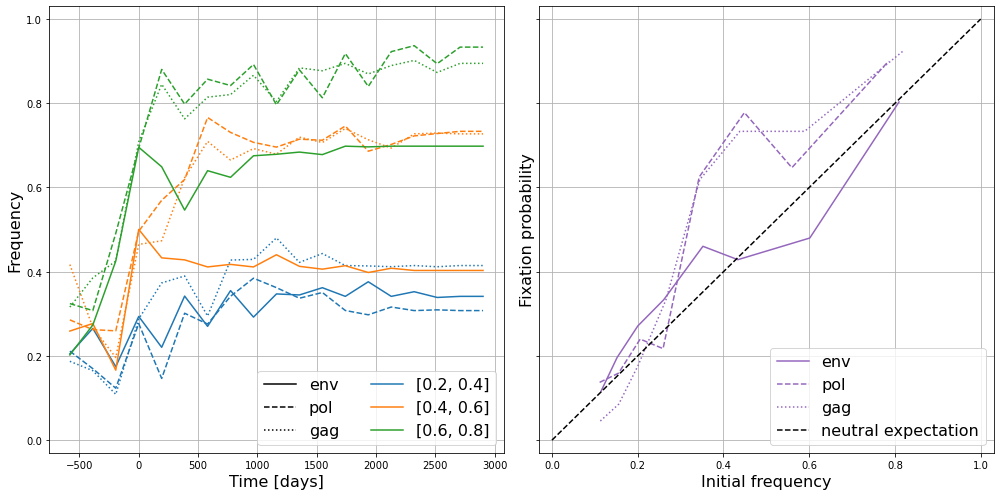

In [5]:
fontsize=16
grid_alpha = 0.5
colors = ["C0","C1","C2","C4"]
markersize=12
freq_ranges = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8]]
regions = ["env","pol","gag"]
lines = ["-","--",":"]


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,7), sharey=True)

# Plot left
for ii, freq_range in enumerate(freq_ranges):
    for jj, region in enumerate(regions):
        axs[0].plot(times, means[str(freq_range)][region]["non_syn"], lines[jj], color=colors[ii])
        
line1, = axs[0].plot([0], [0], "k-")
line2, = axs[0].plot([0], [0], "k--")
line3, = axs[0].plot([0], [0], "k:")
line4, = axs[0].plot([0], [0], "-", color=colors[0])
line5, = axs[0].plot([0], [0], "-", color=colors[1])
line6, = axs[0].plot([0], [0], "-", color=colors[2])

axs[0].set_xlabel("Time [days]", fontsize=fontsize)
axs[0].set_ylabel("Frequency", fontsize=fontsize)
axs[0].set_ylim([-0.03, 1.03])
axs[0].grid(grid_alpha)
axs[0].legend([line1, line2, line3, line4, line5, line6], regions + ["[0.2, 0.4]", "[0.4, 0.6]", "[0.6, 0.8]"], fontsize=fontsize, ncol=2)

# Plot right

for ii,region in enumerate(regions):
    axs[1].plot(pfix[region]["non_syn"]["freq_bin"], pfix[region]["non_syn"]["proba"], lines[ii], color=colors[3])

axs[1].plot([0,1], [0,1], "k--")
axs[1].set_xlabel("Initial frequency", fontsize=fontsize)
axs[1].set_ylabel("Fixation probability", fontsize=fontsize)
axs[1].set_ylim([-0.03, 1.03])
axs[1].set_xlim([-0.03, 1.03])
axs[1].grid(grid_alpha)
plt.legend(["env", "pol", "gag", "neutral expectation"], fontsize=fontsize, loc="lower right")

plt.tight_layout()
plt.show()


In [6]:
print(pfix["pol"]["non_syn"]["proba"])
print(pfix["pol"]["non_syn"]["freq_bin"])

[0.13725490196078433, 0.1590909090909091, 0.24, 0.21739130434782608, 0.625, 0.7777777777777778, 0.6470588235294118, 0.9]
[0.11119173387823389, 0.15520017992350052, 0.2057176964443208, 0.2591570637522348, 0.3434756444678011, 0.44886564000815465, 0.5595444865487352, 0.7850634665485263]
